# Visual analytics and diagnostics of model fit for linear regression

### Dr. Tirthajyoti Sarkar
### Fremont, CA 94536, June 2019

In this notebook, we show the basic visual analytics and diagnostic tests that should be run after fitting a linear regression model, for **checking the goodness of fit by verifying the fundamental assumptions of linear regression** - *linearity, independence, constant variance,* and *normality*. In particular, following analytics are shown,

* Pairwise scatterplot of the data matrix
* Correlation matrix and heatmap
* Creating a new dataset of predicting features and their statistical significance (based on p-values)
* Residuals vs. predicting variables plots
* Fitted vs. residuals plot
* Histogram of the normalized residuals
* Q-Q plot of the normalized residuals
* Shapiro-Wilk normality test on the residuals
* Cook's distance plot of the residuals
* Variance inflation factor (VIF) of the predicting features

### Requirements

* Python 3.6+
* `Numpy`
* `Pandas`
* `Seaborn`
* `Statsmodels`
* `Scipy`

### The dataset

We analyze the **[Concrete Compressive Strength Data Set](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)** from UCI ML repository in this notebook.

***Abstract***: Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. Can we predict the strength from other measurement values?

#### Data Set Information:

* Number of instances: 1030 
* Number of Attributes: 9 
* Attribute breakdown	8 quantitative input variables, and 1 quantitative output variable 
* Missing Attribute Values: None 

### Import the libraries and read the data in

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

In [2]:
# The dataset path may be different in your situation. Please use the correct path
df = pd.read_excel("Datasets/example2-1.xlsx")

In [3]:
df.head(10)

,i,yi,xi
0,1,2158.70,15.50
1,2,1678.15,23.75
2,3,2316.00,8.00
3,4,2061.30,17.00
4,5,2207.50,5.50
5,6,1708.30,19.00
6,7,1784.70,24.00
7,8,2575.00,2.50
8,9,2357.90,7.50
9,10,2256.70,11.00


In [4]:
# .T transposes the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
i,20.0,10.5000,5.916080,1.00,5.750,10.50,15.2500,20.0
yi,20.0,2131.3575,298.570066,1678.15,1783.475,2182.85,2342.0375,2654.2
xi,20.0,13.3625,7.631511,2.00,7.125,12.75,19.6250,25.0


### Taking a peek at the relationship between the predicting variables and the response

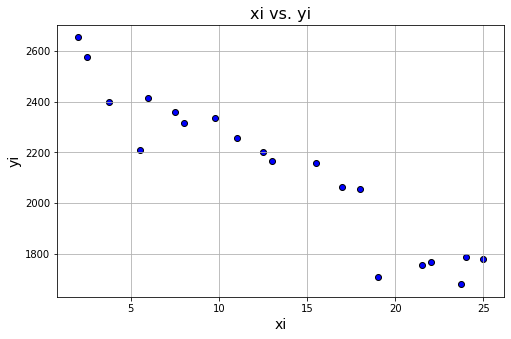

In [15]:
for c in df.columns[2:]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. yi".format(c),fontsize=16)
    plt.scatter(x=df[c],y=df['yi'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('yi',fontsize=14)
    plt.show()

### Creating a copy with suitable column names for processing with `statsmodels.OLS()`

In [17]:
df1 = df[['yi','xi']].copy()

In [18]:
df1.columns=['x']+['y']

In [19]:
df1.head()

,x,y
0,2158.70,15.50
1,1678.15,23.75
2,2316.00,8.00
3,2061.30,17.00
4,2207.50,5.50


### Pairwise scatter plots

In [20]:
from seaborn import pairplot

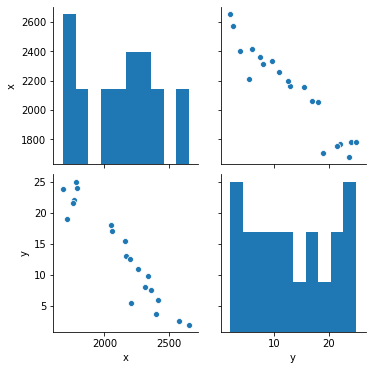

In [21]:
pairplot(df1)

### Correlation matrix and heatmap to visually check for [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)

In [22]:
corr = df1[:-1].corr()

In [23]:
corr

,x,y
x,1.000000,-0.946796
y,-0.946796,1.000000


In [24]:
from statsmodels.graphics.correlation import plot_corr

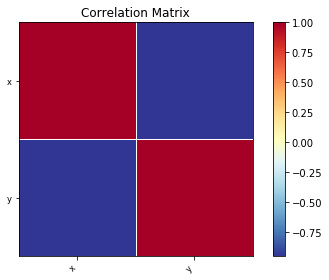

In [25]:
fig=plot_corr(corr,xnames=corr.columns)

### Creating a formula string for using in the `statsmodels.OLS()`

In [26]:
formula_str = df1.columns[-1]+' ~ '+'+'.join(df1.columns[:-1])

In [27]:
formula_str

'y ~ x'

### Construct and fit the model. Print summary of the fitted model

In [28]:
model=sm.ols(formula=formula_str, data=df1)

In [29]:
fitted = model.fit()

In [33]:
fitted.conf_int(alpha=0.05, cols=None)

,0,1
Intercept,56.567250,73.628045
x,-0.028239,-0.020308


In [30]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     165.4
Date:                Sat, 04 Jul 2020   Prob (F-statistic):           1.64e-10
Time:                        15:08:27   Log-Likelihood:                -45.300
No. Observations:                  20   AIC:                             94.60
Df Residuals:                      18   BIC:                             96.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     65.0976      4.060     16.033      0.0

## SciPY linear regression:


In [31]:
from scipy import stats

In [32]:
x = df['xi'].tolist()
y = df['yi'].tolist()
# Perform the linear regression:


slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))

slope: -37.153591    intercept: 2627.822359


### A new Result dataframe: p-values and statistical significance of the features 

In [27]:
df_result=pd.DataFrame()

In [28]:
df_result['pvalues']=fitted.pvalues[1:]

In [29]:
df_result['Features']=df.columns[:-1]

In [30]:
df_result.set_index('Features',inplace=True)

In [35]:
def yes_no(b):

    if b:
        return 'Yes'
    else:
        return 'No'

In [36]:
df_result['Statistically significant?']= df_result['pvalues'].apply(yes_no)

In [26]:
df_result

,pvalues,Statistically significant?
Features,,
Cement (component 1)(kg in a m^3 mixture),1.962842e-41,Yes
Blast Furnace Slag (component 2)(kg in a m^3 mixture),1.633083e-23,Yes
Fly Ash (component 3)(kg in a m^3 mixture),5.029952e-12,Yes
Water (component 4)(kg in a m^3 mixture),1.937337e-04,Yes
Superplasticizer (component 5)(kg in a m^3 mixture),1.920901e-03,Yes
Coarse Aggregate (component 6)(kg in a m^3 mixture),5.522656e-02,Yes
Fine Aggregate (component 7)(kg in a m^3 mixture),5.996805e-02,Yes
Age (day),5.841045e-82,Yes


#### All the predicting variables are statisticall significant with the [threshold of p-value <0.01](https://www.statsdirect.com/help/basics/p_values.htm)

### Residuals vs. predicting variables plots

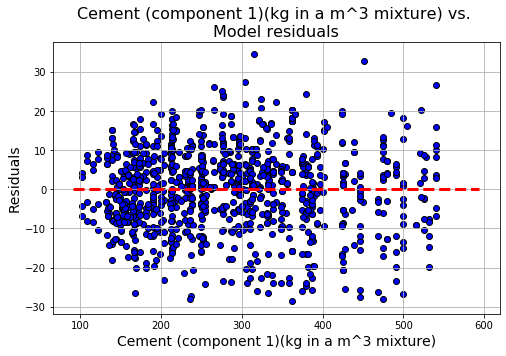

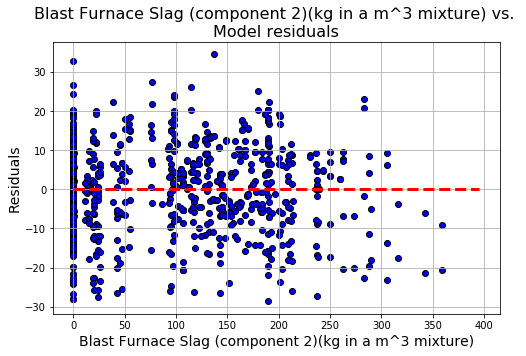

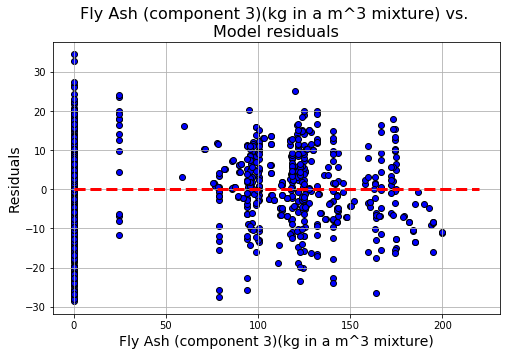

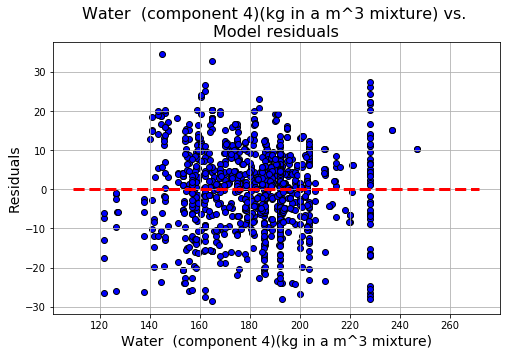

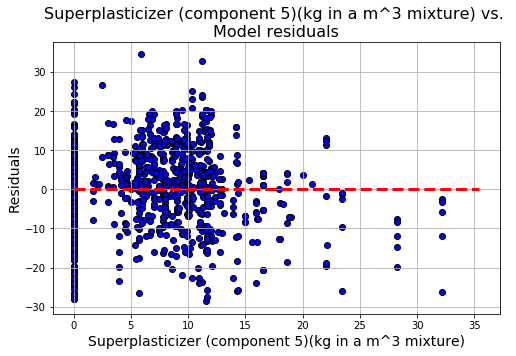

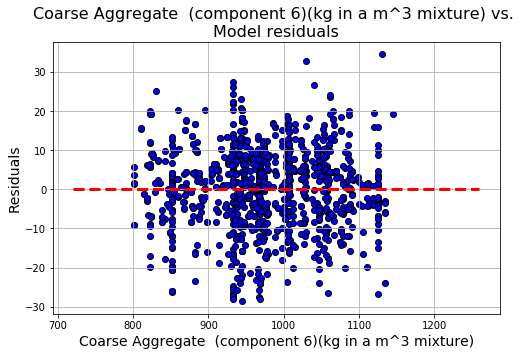

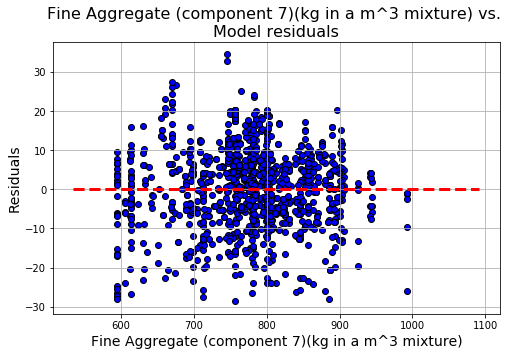

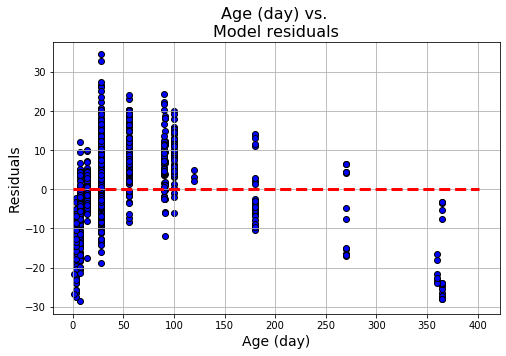

In [37]:
for c in df.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=df[c],y=fitted.resid,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(df[c])
    xmax = max(df[c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()

#### Residual plots show some bit of clustering but overall the assumptions linearity and independence seem to hold because the distribution seem random around the 0 axis.

### Fitted vs. residuals

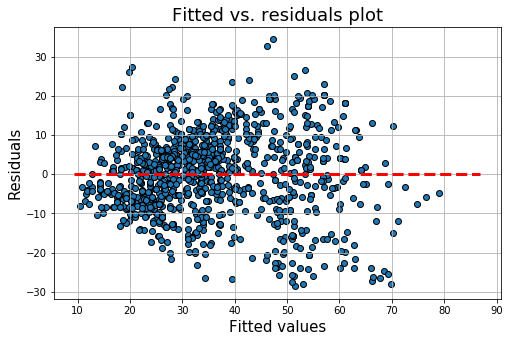

In [38]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

#### The fitted vs. residuals plot shows violation of the constant variance assumption - [Heteroscedasticity](http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html).

### Histogram of normalized residuals

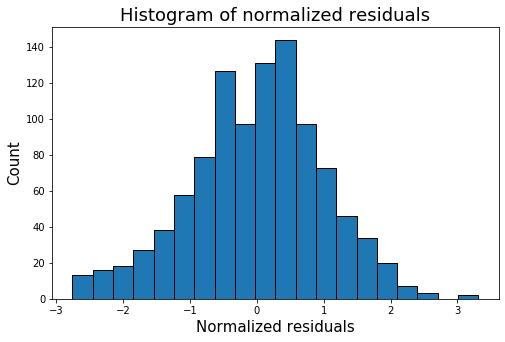

In [39]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

### Q-Q plot of the residuals

In [40]:
from statsmodels.graphics.gofplots import qqplot

<Figure size 576x360 with 0 Axes>

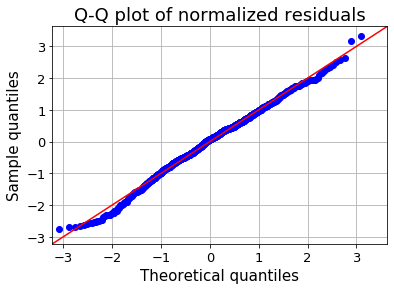

In [41]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

#### The Q-Q plot (and the histogram above) shows that the normality assumption is satisfied pretty good 

### Normality (Shapiro-Wilk) test of the residuals

In [42]:
from scipy.stats import shapiro

In [43]:
_,p=shapiro(fitted.resid)

In [44]:
if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


### Cook's distance (checking for outliers in residuals)

In [45]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [46]:
inf=influence(fitted)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


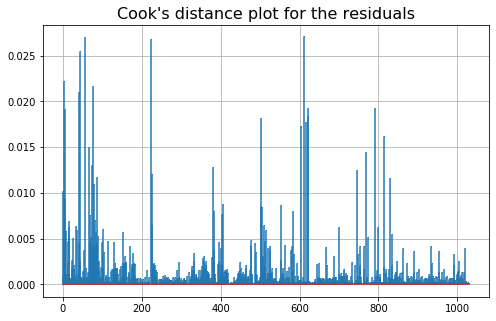

In [47]:
(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()

#### There are few data points with residuals being possible outliers

### Variance inflation factor

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [49]:
for i in range(len(df1.columns[:-1])):
    v=vif(np.matrix(df1[:-1]),i)
    print("Variance inflation factor for {}: {}".format(df.columns[i],round(v,2)))

Variance inflation factor for Cement (component 1)(kg in a m^3 mixture): 26.23
Variance inflation factor for Blast Furnace Slag (component 2)(kg in a m^3 mixture): 4.44
Variance inflation factor for Fly Ash (component 3)(kg in a m^3 mixture): 4.56
Variance inflation factor for Water  (component 4)(kg in a m^3 mixture): 92.59
Variance inflation factor for Superplasticizer (component 5)(kg in a m^3 mixture): 5.52
Variance inflation factor for Coarse Aggregate  (component 6)(kg in a m^3 mixture): 85.97
Variance inflation factor for Fine Aggregate (component 7)(kg in a m^3 mixture): 73.46
Variance inflation factor for Age (day): 2.43


#### There are few features with VIF > 10, thereby indicating significant multicollinearity